# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import pandas as pd
import math


# training, validation, and testing file locations
training_file = '../data/train.p'
validation_file= '../data/valid.p'
testing_file = '../data/train.p'

# open/read the three files
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# labels/classes of traffic-signs
sign_names = pd.read_csv('./signnames.csv')
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
classes = sign_names['ClassId']
class_names = sign_names['SignName']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES** 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
print("Size of:")

# Number of training examples
n_train = len(X_train)
print("- Training-set:\t\t{}".format(n_train))

# Number of validation examples
n_validation = len(X_validation)
print("- Validation-set:\t{}".format(n_validation))

# Number of testing examples.
n_test = len(X_test)
print("- Test-set:\t\t{}".format(n_test))

# What's the shape of an traffic sign image?
img_shape = X_train.shape[1:4]
print("- Image Shape:\t\t{}".format(img_shape))

# How many unique classes/labels there are in the dataset.
# unique_classes = classes.shape[0]
# print("- Number of Classes:\t{}".format(unique_classes))

Size of:
- Training-set:		34799
- Validation-set:	4410
- Test-set:		34799
- Image Shape:		(32, 32, 3)


### Graph visualization of dataset

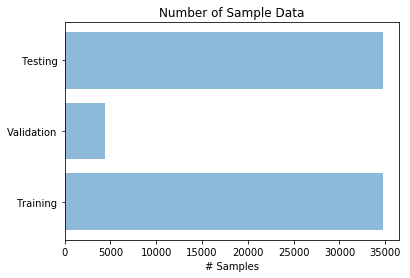

In [3]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import numpy as np
import random

fig, ax = plt.subplots()

sample_header = ('Training', 'Validation', 'Testing')
num_samples = (n_train, n_validation, n_test)

y_pos = np.arange(len(sample_header))

plt.barh(y_pos, num_samples, align='center', alpha=0.5)
plt.yticks(y_pos, sample_header)
plt.xlabel('# Samples')
plt.title('Number of Sample Data')

plt.show()

### Visualization of Images and Labels

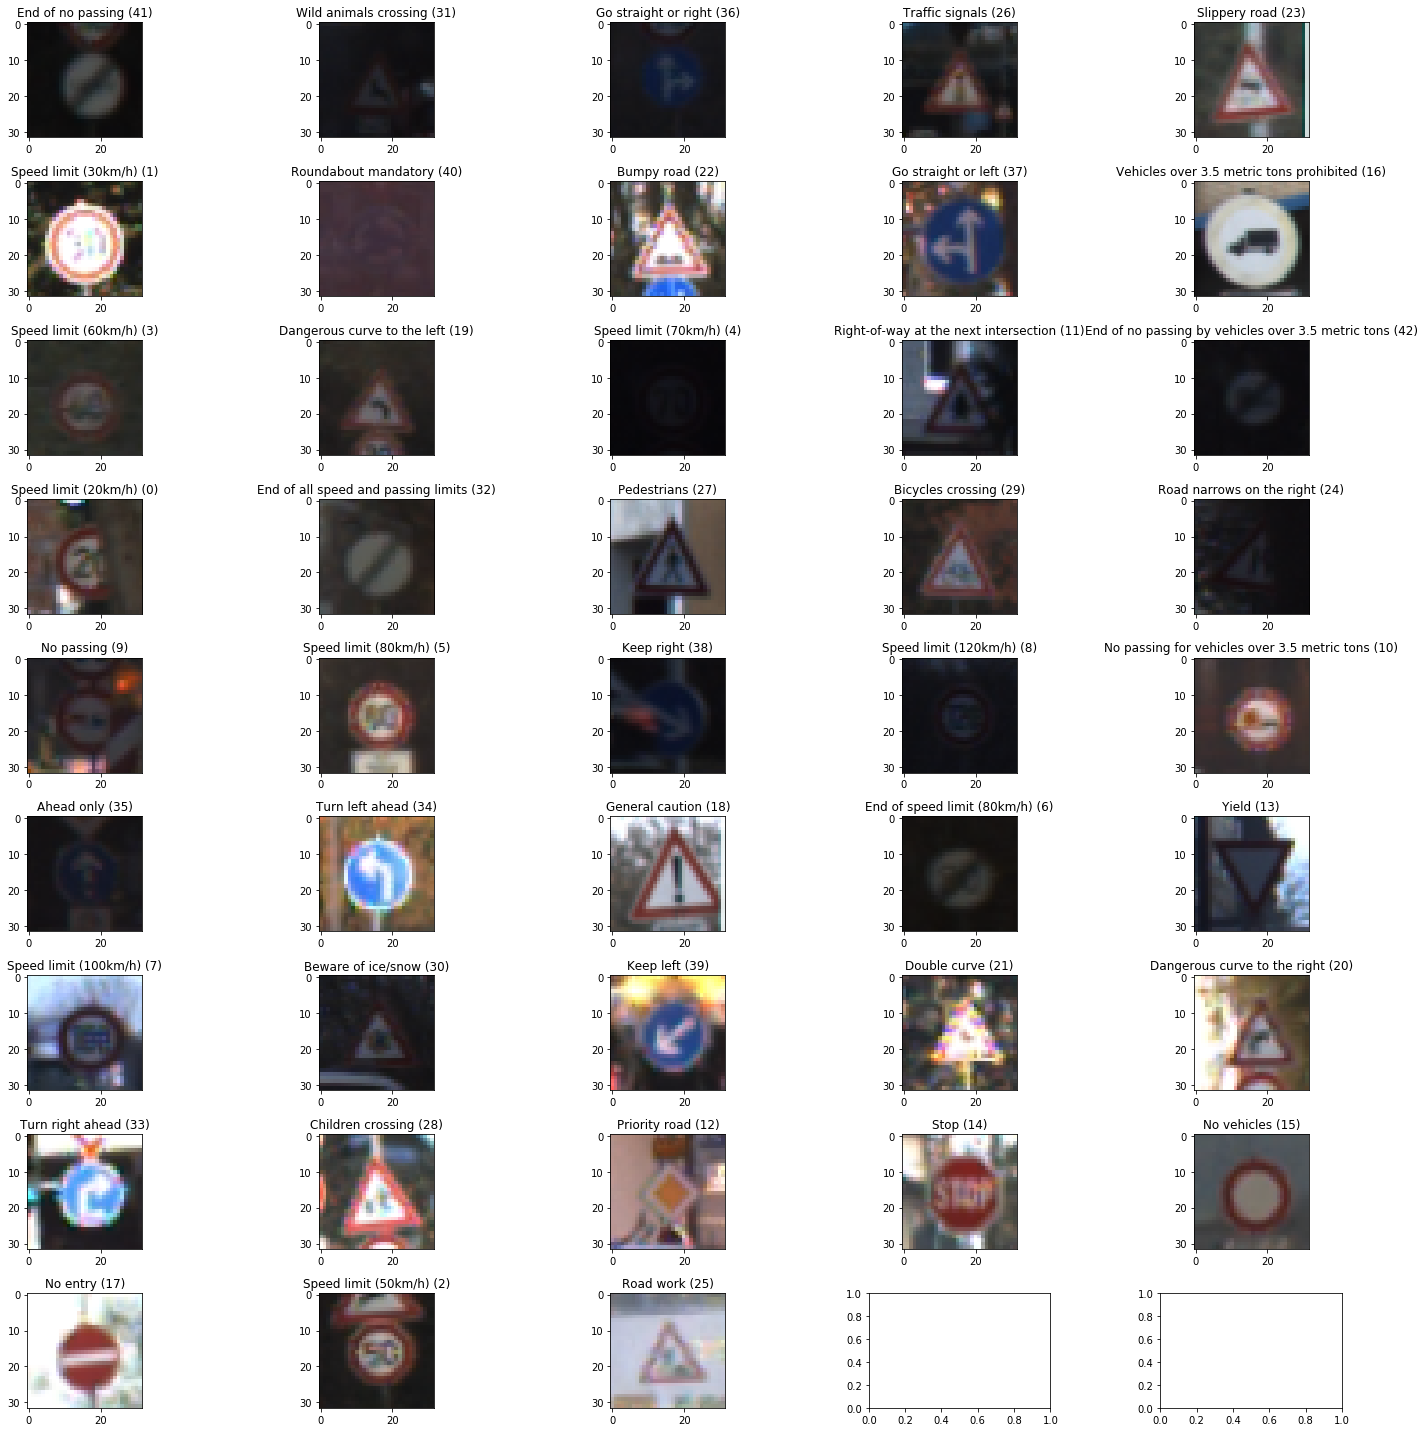

In [4]:
def visualize_classes(features, feature_labels, label_list):
    """
    Visualize images along with label name
    
    Params:
        features - array of images
        feature_labels - corresponding label for each image in features
        label_list - list of label index and corresponding label name
    """
    
    # list of signs that have been displayed
    displayed_labels = []
    
    # number of columns
    ncols = 5
    
    # calculates number of rows based on ncols
    nrows = math.ceil(len(label_list) / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

    # row index.
    row = 0
    # column index.
    col = 0

    for idx, label in enumerate(feature_labels):

        # if label hasn't been displayed
        if label not in displayed_labels:

            # append unseen label to displayed_labels.
            displayed_labels.append(label)

            # image title
            axes[row][col].set_title(label_list[label] + ' (' + str(label) + ')')

            # displays image
            axes[row][col].imshow(features[idx])

            # control which row and column image is displayed in.
            if col == ncols - 1:
                col = 0
                row +=1
            else:
                col += 1

    # sets layout for rows and columns            
    plt.tight_layout()
    
visualize_classes(X_validation, y_validation, class_names)

----

## Step 2: Design and Test a Model Architecture

### Data Set Pre-Processing

In [5]:
def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    x_min = 0
    x_max = 255
    a = 0.1
    b = 0.9

    return np.add(a, np.multiply(np.subtract(image_data, x_min), np.divide(np.subtract(b,a), np.subtract(x_max, x_min))))
    
X_train = normalize(X_train)
X_validation = normalize(X_validation)
X_test = normalize(X_test)

## Shuffle Data

In [6]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [7]:
import tensorflow as tf

EPOCHS = 6
BATCH_SIZE = 64

In [8]:
def conv2(inputs, filter_size, stride, in_depth, out_depth, mu, sigma):
    
    conv_W = tf.Variable(tf.truncated_normal(shape=(filter_size, filter_size, in_depth, out_depth), mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(out_depth))
    conv   = tf.nn.conv2d(inputs, conv_W, strides=[1, stride, stride, 1], padding='VALID') + conv_b
    
    return conv
    
    
def max_pool(inputs, kernel_size, stride):
    
    return tf.nn.max_pool(inputs, ksize=[1, kernel_size, kernel_size, 1], strides=[1, stride, stride, 1], padding='VALID')


def fully_connected(inputs, in_shape, out_shape, mu, sigma):
    
    fc_W = tf.Variable(tf.truncated_normal(shape=(in_shape, out_shape), mean = mu, stddev = sigma))
    fc_b = tf.Variable(tf.zeros(out_shape))
    fc   = tf.matmul(inputs, fc_W) + fc_b
    
    return fc

In [9]:
from tensorflow.contrib.layers import flatten

def LeNet(x):
    
    mu = 0
    sigma = 0.1

    # Layer 1: (1 X 1) Convolution
    network = conv2(x, 1, 1, 3, 32, mu, sigma)
    network = tf.nn.relu(network)
    
    # Layer 2: (3 X 3) Convolution
    network = conv2(network, 3, 1, 32, 32, mu, sigma)
    network = tf.nn.relu(network)
    
    # Layer 3: (3 X 3) Convolution
    network = conv2(network, 3, 1, 32, 64, mu, sigma)
    network = tf.nn.relu(network)
    network = max_pool(network, 1, 2)
    
    # Layer 4: Dropout Layer @ 50%
    network = tf.nn.dropout(network, keep_prob)
    
    # Layer 5: (3 X 3) Convolution
    network = conv2(network, 3, 1, 64, 64, mu, sigma)
    network = tf.nn.relu(network)
    
    # Layer 6: (3 X 3) Convolution
    network = conv2(network, 3, 1, 64, 128, mu, sigma)
    network = tf.nn.relu(network)
    
    network = max_pool(network, 1, 2)
    
    # Layer 7: Dropout Layer @ 50%
    network = tf.nn.dropout(network, keep_prob)
    
    # Layer 8: (3 X 3) Convolution
    network = conv2(network, 3, 1, 128, 128, mu, sigma)
    network = tf.nn.relu(network)
    
    # Layer 9: (3 X 3) Convolution
    network = conv2(network, 3, 1, 128, 256, mu, sigma)
    network = tf.nn.relu(network)
    network = max_pool(network, 1, 2)
    
    # Layer 10: Dropout Layer @ 50%
    network = tf.nn.dropout(network, keep_prob)

    network = flatten(network)
    
    # Layer 11: Fully Connected Layer
    network = fully_connected(network, 256, 84, mu, sigma)
    
    # Layer 12: Fully Connected Layer
    return fully_connected(network, 84, 43, mu, sigma)

## Features and Labels

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline

In [11]:
rate = 0.001

keep_prob = tf.placeholder(tf.float32, ())

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evalutation

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './KentNet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.884
Validation Accuracy = 0.829

EPOCH 2 ...
Training Accuracy = 0.957
Validation Accuracy = 0.929

EPOCH 3 ...
Training Accuracy = 0.978
Validation Accuracy = 0.954

EPOCH 4 ...
Training Accuracy = 0.988
Validation Accuracy = 0.959

EPOCH 5 ...
Training Accuracy = 0.989
Validation Accuracy = 0.969

EPOCH 6 ...
Training Accuracy = 0.994
Validation Accuracy = 0.973

Model saved


---

## Step 3: Test a Model on New Images

### Format Image Shape

In [13]:
from PIL import Image

def format_images(num_imgs):
    
    parent_dir = './traffic-signs-data/prediction/'
    images_array = []

    for i in range(num_imgs):

        # open image with Pillow
        img = Image.open(parent_dir + 'img_' + str(i) + '.JPG')

        # resize image to (32, 32) with Pillow
        img = img.resize((32, 32))

        # convert Pillow object to numpy array
        img = np.asarray(img)

        # re-structure image
        img = img.reshape(32, 32, 3)
        
        # append image array to prediction_images array
        images_array.append(img)

    return np.array(images_array)

### Load and Output the Images

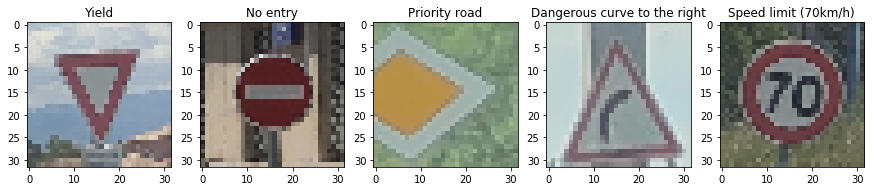

In [14]:
# Normailized and formatted images
predict_images = normalize(format_images(5))

# label index for each image from signnames.csv
labels = [13, 17, 12, 20, 4]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

for i in range(len(predict_images)):
    
    axes[i].set_title(class_names[labels[i]])
    axes[i].imshow(predict_images[i])

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./KentNet


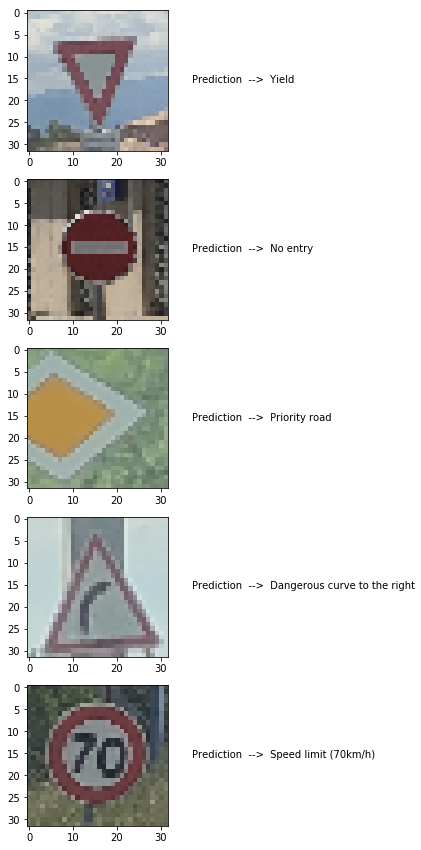

In [15]:
# Make predictions for the unseen images
softmax = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax, k=1)
checkpoint_file = tf.train.latest_checkpoint('./KentNet')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './KentNet')
    softmax_res = sess.run(softmax, feed_dict={x: predict_images, keep_prob: 1.0})
    top_k_res = sess.run(top_k, feed_dict={x: predict_images, keep_prob: 1.0})
    
    
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 15))
    
    for i in range(len(top_k_res[1])):
        
        top_pos = predict_images.shape[1] / 2
        left_pos = predict_images.shape[1] + 5
        
        label = class_names[top_k_res[1][i][0]]
        
        axes[i].text(left_pos, top_pos, 'Prediction  -->  ' + label)
        axes[i].imshow(predict_images[i])

### Analyze Performance

In [16]:
# Calculated accuracy for these 5 new images. 
# For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './KentNet')

    test_accuracy = evaluate(predict_images, labels)
    print("Prediction Set Accuracy = {:.2f} %".format(test_accuracy * 100))

INFO:tensorflow:Restoring parameters from ./KentNet
Prediction Set Accuracy = 100.00 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./KentNet


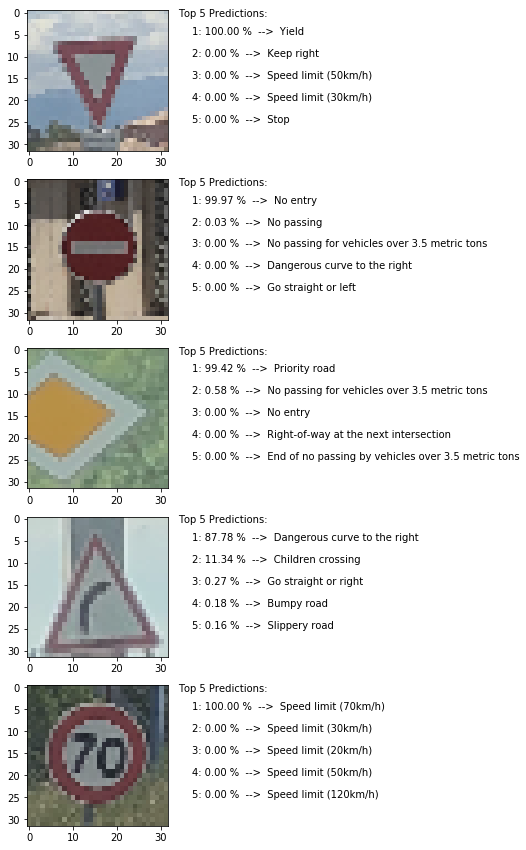

In [17]:
# Top five softmax probabilities for the predictions on the German traffic sign images found on the web.
softmax = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax, k=5)
checkpoint_file = tf.train.latest_checkpoint('./KentNet')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, './KentNet')
    softmax_res = sess.run(softmax, feed_dict={x: predict_images, keep_prob: 1.0})
    top_k_res = sess.run(top_k, feed_dict={x: predict_images, keep_prob: 1.0})
    
    # shape of top_k_output
    top_k_shape = top_k_res[0].shape
    
    # prepare plotting structure
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 15))
    
    
    for i in range(top_k_shape[0]):
        
        # display image being classified
        axes[i].imshow(predict_images[i])
        
        # distance from top of column
        top_pos = 5
        
        # distance from left of column
        left_pos = predict_images.shape[1] + 5
        
        # header label
        axes[i].text(left_pos - 3, 1, 'Top ' + str(top_k_shape[1]) + ' Predictions:')
        
        for j in range(top_k_shape[1]):
            
            # predicted image label
            label = class_names[top_k_res[1][i][j]]
            
            # probability of classification
            prediction = '{0:.2f}'.format(top_k_res[0][i][j] * 100) + ' %  -->  '

            # displays label and prediction besides image
            axes[i].text(left_pos, top_pos, str(j + 1) + ': ' + prediction + label)
            
            # creates space between each prediction
            top_pos += 5

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [19]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
outputFeatureMap(predict_images[0], conv2)